# LDA implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import os

import math
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.ops.indexing import Vindex
from torch.distributions import constraints

from zzz_utils import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig(format='%(message)s', level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(1)

## LDA model

First we simulate a toy dataset to render the Pyro models.

In [2]:
nTopics = 3    # Topics
nCells = 50    # Cells
nRegions = 100 # Regions
N = [30] * nCells # Cells size

# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = [1] * nTopics, b = [1] * nRegions)
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

Below we define the LDA model with Pyro. Note that data D is a matrix of UMI x Cells, and here we assume that nUMI is the same across cells.

In [3]:
def model(D=None, nTopics=5, nRegions=100, nCells=50, N=10):
    if D is not None:
        nCells = D.shape[1]
        N = D.shape[0]
    
    ## Globals
    # Topic-cells prior
    a = pyro.param("a", torch.ones(nTopics))
    # Topic-regions prior
    b = pyro.param("b", torch.ones(nRegions) / 100)
    # For each topic generate topic-region distribution
    with pyro.plate("nTopics", nTopics):
        phi = pyro.sample("phi", dist.Dirichlet(b))
    
    ## Locals
    with pyro.plate("nCells", nCells):
        # Topic-cells distribution
        theta = pyro.sample("theta", dist.Dirichlet(a))
        with pyro.plate("nCounts", N):
            z = pyro.sample("z", dist.Categorical(theta), infer = {"enumerate" : "parallel"})
            phi_z = Vindex(phi)[z, :]
            w = pyro.sample("w", dist.Categorical(phi_z), obs = D)
            
    return w, theta, phi

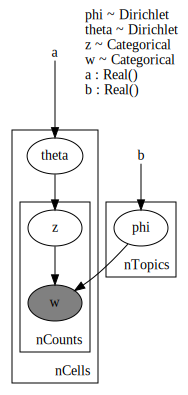

In [4]:
pyro.clear_param_store()
pyro.render_model(model, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

## LDA simple guide

In [5]:
pyro.clear_param_store()
def guide(D=None, nTopics=5, nRegions=100, nCells=50, N=10):
    if D is not None:
        nCells = D.shape[1]
        N = D.shape[0]
    
    ## Globals
    a_vi = pyro.param("a_vi", lambda: torch.ones(nTopics) + torch.Tensor(list(range(nTopics))), 
                      constraint=constraints.positive)
    b_vi = pyro.param("b_vi", lambda: torch.ones(nRegions), 
                      constraint=constraints.positive)
    
    # Iterate over topics
    with pyro.plate("nTopics", nTopics):
        phi = pyro.sample("phi", dist.Dirichlet(b_vi))
    
    # Iterate over cells
    with pyro.plate("nCells", nCells):
        # Topic-cells distribution
        theta = pyro.sample("theta", dist.Dirichlet(a_vi))
    
    return {"theta":theta, "phi":phi}

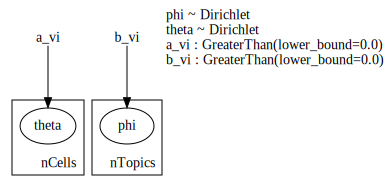

In [6]:
pyro.render_model(guide, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

## Testing variational inference

In [7]:
# Simulate data
nTopics = 2    # Topics
nCells = 1000    # Cells
nRegions = 300 # Regions
N = [100] * nCells # Cells size
a = [1/5] * nTopics
b = [1/10] * nRegions
# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = a, b = b)
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

In [8]:
D.shape

torch.Size([100, 1000])

Guessed max_plate_nesting = 2
Elbo loss: 0:	 604723.3125
Elbo loss: 100:	 589004.0
Elbo loss: 200:	 566698.75
Elbo loss: 300:	 574603.875
Elbo loss: 400:	 558384.5625
Elbo loss: 500:	 545708.1875
Elbo loss: 600:	 536495.5625
Elbo loss: 700:	 517826.34375
Elbo loss: 800:	 517593.4375
Elbo loss: 900:	 509687.3125


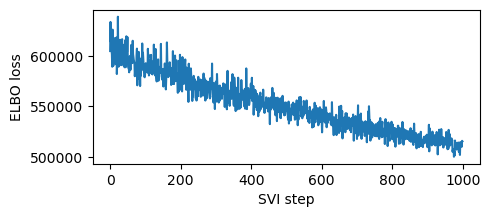

In [9]:
pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.001})
elbo = pyro.infer.TraceEnum_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(D = D, nTopics = nTopics, nRegions = nRegions)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}:\t {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [10]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

a_vi [5.7438354 5.7853546]
b_vi [16.113096    0.5810938   0.06357079  1.295876    0.18223232  0.73043334
  0.18285677  0.08167242  0.5728276   0.74641395  0.12529978  0.06397581
  0.06375959  0.08788694  6.9566903   0.06446893  0.06951516  3.4159455
 15.006647    0.951818    0.06127118  0.48262826  0.06837656  1.8483162
  0.06176449 23.600777   21.311626    0.07079117  0.3711881   0.0611961
  0.13566193  1.1432781   9.144945    8.593284    0.06890693  0.06060671
  0.37478387 23.16552     0.07881644  1.3446784   8.428881    0.06364483
  1.9925752   3.698836    0.4028504   0.61812013  2.4895513   0.06061513
  0.06437548  0.06580375  1.2273372   2.157617    7.9197154   0.06867384
  2.259068    0.7726643  11.007779   10.010868   12.528034    0.06141991
  0.24169129 10.34296     0.07140841  0.7164291  11.196639    1.3569908
  0.07753405 16.614563    0.0756719   1.197492    0.08995122  0.06199316
  0.05892093  0.45777157  0.06196049 19.324059    0.06838232  0.0751527
  0.06466193  1.1180775 

In [26]:
with pyro.plate("nsample", 800, dim=-1):
    samples = guide(D = D, nTopics = nTopics, nRegions = nRegions)

theta = samples["theta"]
phi = samples["phi"]

In [27]:
phi.mean(-2)

tensor([[1.6938e-02, 6.0609e-04, 6.1293e-05, 1.3508e-03, 2.1896e-04, 7.8933e-04,
         1.6198e-04, 1.0527e-04, 5.8741e-04, 7.7684e-04, 1.2455e-04, 6.8476e-05,
         5.7797e-05, 8.7903e-05, 7.1945e-03, 7.8512e-05, 7.1862e-05, 3.5734e-03,
         1.5398e-02, 9.1042e-04, 7.4152e-05, 5.5166e-04, 8.2050e-05, 1.9227e-03,
         6.4505e-05, 2.4469e-02, 2.2302e-02, 6.6073e-05, 3.9390e-04, 7.2965e-05,
         1.7292e-04, 1.1934e-03, 9.6007e-03, 8.8345e-03, 6.8235e-05, 7.5631e-05,
         3.8678e-04, 2.4009e-02, 7.6404e-05, 1.3657e-03, 8.6682e-03, 7.5848e-05,
         1.9888e-03, 3.9282e-03, 4.0051e-04, 5.9182e-04, 2.6701e-03, 6.9501e-05,
         7.0168e-05, 8.2061e-05, 1.3283e-03, 2.2242e-03, 8.2913e-03, 7.3053e-05,
         2.4370e-03, 7.8106e-04, 1.1527e-02, 1.0498e-02, 1.2847e-02, 6.4328e-05,
         2.5357e-04, 1.0717e-02, 6.5544e-05, 6.9733e-04, 1.1760e-02, 1.4045e-03,
         8.6092e-05, 1.7131e-02, 7.6363e-05, 1.2339e-03, 6.5536e-05, 6.4858e-05,
         8.0618e-05, 4.6201e

In [ ]:
tmp = theta.sum(-2)
tmp.shape

In [ ]:
theta.mean(-2)

In [25]:
guide(D = D, nTopics = nTopics, nRegions = nRegions)

{'theta': tensor([[0.4667, 0.5333],
         [0.3677, 0.6323],
         [0.4131, 0.5869],
         ...,
         [0.4562, 0.5438],
         [0.5869, 0.4131],
         [0.7418, 0.2582]], grad_fn=<_DirichletBackward>),
 'phi': tensor([[1.6881e-02, 2.3032e-04, 1.4607e-05, 1.5120e-03, 6.5055e-04, 1.0925e-03,
          2.1178e-05, 8.9375e-08, 1.4888e-03, 2.1989e-04, 7.3866e-08, 1.1199e-09,
          2.2229e-11, 2.3108e-09, 4.3292e-03, 3.4862e-09, 3.4564e-13, 2.3106e-03,
          1.3408e-02, 2.3741e-04, 4.8823e-14, 4.2528e-05, 1.0179e-04, 4.5939e-03,
          2.1792e-16, 1.4443e-02, 1.8882e-02, 1.3054e-13, 1.8731e-04, 2.9153e-05,
          3.8283e-06, 1.1509e-03, 8.1939e-03, 9.0342e-03, 1.7697e-08, 1.9363e-13,
          4.1752e-03, 1.9482e-02, 5.5165e-07, 1.1520e-04, 1.3498e-02, 4.3262e-25,
          2.5818e-03, 3.0518e-03, 1.0772e-05, 5.8650e-04, 4.3079e-03, 4.7124e-08,
          2.0165e-15, 4.4546e-09, 3.2274e-03, 1.2722e-03, 1.0937e-02, 2.0142e-07,
          6.0105e-03, 1.7051e-04, 1.32